![EEG%20Motor%20Imagery%20Dataset.png](attachment:EEG%20Motor%20Imagery%20Dataset.png)

In [ ]:
!pip install mne

     |████████████████████████████████| 7.4 MB 9.7 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Import Dependancies

In [ ]:
import numpy as np
import mne
import os
import sys
from mne.datasets import eegbci
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
mne.set_log_level('WARNING')

#### Motor Imagery class for Pre-processing

In [ ]:
class motorImagery:
    def __init__(self, path=None, subjects=[1], runs=[1]):
        self.path = path
        self.edf_filenames = self.get_filenames(path)
        self.raw = self.load_eeg(subjects, runs)
        
    def get_filenames(self, path):
        file = open(dataset_path+'RECORDS')
        edf_filenames = file.readlines()
        file.close()
        edf_filenames = [fname.rstrip() for fname in edf_filenames]
        return edf_filenames
    
    def load_eeg(self, subjects, runs):    #load -> standardize -> notch_filter -> bandpass filter -> return
    
        fno = self.get_fileIndices(subjects, runs)
        print('Loading files at index:', fno)
        
        raw_eegs = []
        for idx,i in enumerate(fno):
            path_file = os.path.join(self.path, self.edf_filenames[i])
            sys.stdout.write(f"\rLoading file #{idx+1}/{len(fno)}: {path_file}")
            raw = mne.io.read_raw_edf( path_file , preload=True, verbose='WARNING' )
            raw_eegs.append(raw)

        raw = mne.io.concatenate_raws(raw_eegs)     # Concatenate all EEGs together
        eegbci.standardize(raw)                     # Standardize channel names
        montage = mne.channels.make_standard_montage('standard_1005')
        raw.set_montage(montage)
        return raw                                  
    
    def get_fileIndices(self, subjects, runs):
        fno = []
        subjects = [s-1 for s in subjects]  # start from 0, 1, 2, ...
        for subject in subjects:
            for run in runs:
                fno.append(subject*14+run-1)   # 14 runs per subject
        return fno
    
    def apply_filter(self, freq):
        # Remove power line noise atrifacts at 50 Hz <-- European data so 50Hz powerline freq
        #self.raw.notch_filter(50)
        # Remove higher frequencies as they are redundant for analysis.
        low_freq, high_freq = freq
        self.raw.filter(low_freq, high_freq, fir_design='firwin')
        
    def get_ica(self, n=16):
        self.ica = mne.preprocessing.ICA(n_components=n, max_iter='auto', random_state=97)
        self.ica.fit(self.raw)
        self.raw.load_data()
        self.ica.plot_sources(self.raw)
        self.ica.plot_components()
        
    def exclude_ic(self, channels):
        self.ica.exclude = channels
        self.ica.apply(self.raw)

    def get_events(self):
        event_id = dict(T1=2, T2=3)        # Define the events we want to extract
        events, event_id = mne.events_from_annotations(self.raw, event_id=event_id)
        return events, event_id
    
    def get_epochs(self, events, event_id):
        # We don't need it for now but lets include it as it is a part of the pipeline of eeg classification
        picks = mne.pick_types(self.raw.info, eeg=True, exclude='bads')

        # tmin and tmax are relative to the event onset time. They decide the time interval (relative to event onset) taken to 
        # form the epoch from eeg signal. 
        tmin = -1  # A second before event cue 
        tmax = 4   # Four seconds after cue. Most events are of 4.1 or 4.2 seconds long as described in annotations.

        # Read epochs (only the events described in our event_id will be included for training)
        # For future try to use baseline subtraction method 
        epochs = mne.Epochs(self.raw, events, event_id, tmin, tmax, proj=True, 
                            picks=picks, baseline=None, preload=True)

        # Only eeg signals in time interval 1-2 sec will be used for training -> 1 sec after event cue to 2 sec after cue.
        # This is to avoid the evoked potentials arising in brain in response to event cue.
        epochs_train = epochs.copy().crop(tmin=1., tmax=4.)
        montage = mne.channels.make_standard_montage('standard_1005')
        epochs_train.set_montage(montage)
        
        return epochs_train
    
    def downsample(self, epochs, factor):
        return epochs.decimate(factor)
        
    def return_epochs(self, freq=(1, 35), dsamplingFactor=1, channel_selection=False):
        events, event_id = self.get_events()
        self.epochs = self.get_epochs(events, event_id)
        self.epochs = self.downsample(self.epochs, dsamplingFactor)
        self.labels = self.epochs.events[:,-1] - 2        # Convert from 2,3 to 0,1 and assign to labels for training
        if channel_selection:
            self.epochs = self.epochs.pick_channels(self.epochs.ch_names[:21])
        return self.epochs, self.labels
    
    def get_X_y(self, channel_selection=False):
        self.return_epochs(channel_selection=channel_selection)
        return self.epochs.get_data(), self.labels

#### Using SVM to classify Subject EEG signals

1. Apply Bandpass filter
2. Choose n_components for CSP transform
3. Use CSP to extract features
4. Perform Binary Classification using SVM
5. Repeat 1-4 and choose the best model based on accuracy

In [ ]:
def train_model(csp_components, X, y):
    csp = mne.decoding.CSP(n_components=csp_components, norm_trace=True)
    
    lda = LinearDiscriminantAnalysis()
    
    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    scores_lda = []

    for train_idx, test_idx in cv.split(y):
        y_train, y_test = y[train_idx], y[test_idx]

        X_train = csp.fit_transform(X[train_idx], y_train)
        X_test = csp.transform(X[test_idx])

        # fit classifiers
        lda.fit(X_train, y_train)

        scores_lda.append(lda.score(X_test, y_test))
        
            
    return np.mean(scores_lda), lda


In [ ]:
def train(X, y):
    n_components = np.arange(1,25,2)

    accuracy_lda = []
    
    best_model_lda=[]

    best_accuracy_lda=0
    
    for number in n_components:
        lda_score, lda = train_model(int(number), X, y)

        accuracy_lda.append( lda_score )

        if( lda_score>best_accuracy_lda ):
            best_accuracy_lda = lda_score
            best_model_lda = lda
            
    return np.max(accuracy_lda), best_model_lda

In [ ]:
dataset_path = os.path.join("H:\\","BCI Project","eeg-motor-movementimagery-dataset-1.0.0","files\\")
subjects = [1,2,3,4,5,6,7,8,9,10]
runs = [6,10,14]
accuracy=[]
models=[]
f=[(8,40), (4,12), (4,16)]

for subject in subjects:
    best_fband_acc = 0
    accuracy_lda = 0
    for freq in f:
        eeg = motorImagery(dataset_path, [subject], runs)
        eeg.apply_filter(freq=freq)
        X, y = eeg.get_X_y(channel_selection=False)
        accuracy_lda, model = train(X, y)
        if accuracy_lda>best_fband_acc:
            best_fband_acc = accuracy_lda
    accuracy.append(best_fband_acc)
    models.append(model)
    
print(accuracy)

Loading files at index: [5, 9, 13]
Loading file #3/3: H:\BCI Project\eeg-motor-movementimagery-dataset-1.0.0\files\S001/S001R14.edfLoading files at index: [5, 9, 13]
Loading file #3/3: H:\BCI Project\eeg-motor-movementimagery-dataset-1.0.0\files\S001/S001R14.edfLoading files at index: [5, 9, 13]
Loading file #3/3: H:\BCI Project\eeg-motor-movementimagery-dataset-1.0.0\files\S001/S001R14.edfLoading files at index: [19, 23, 27]
Loading file #3/3: H:\BCI Project\eeg-motor-movementimagery-dataset-1.0.0\files\S002/S002R14.edfLoading files at index: [19, 23, 27]
Loading file #3/3: H:\BCI Project\eeg-motor-movementimagery-dataset-1.0.0\files\S002/S002R14.edfLoading files at index: [19, 23, 27]
Loading file #3/3: H:\BCI Project\eeg-motor-movementimagery-dataset-1.0.0\files\S002/S002R14.edfLoading files at index: [33, 37, 41]
Loading file #3/3: H:\BCI Project\eeg-motor-movementimagery-dataset-1.0.0\files\S003/S003R14.edfLoading files at index: [33, 37, 41]
Loading file #3/3: H:\BCI Project\eeg-

   Subject,    Accuracy : 
     1,       0.9888888888888889
     2,       0.9111111111111111
     3,       0.7222222222222223
     4,       0.7111111111111111
     5,       0.6888888888888889
     6,       0.7
     7,       0.9888888888888889
     8,       0.9111111111111111
     9,       0.5555555555555556
     10,       0.7222222222222222
-------------------------------
Average Classification Accuracy: 0.7899999999999999


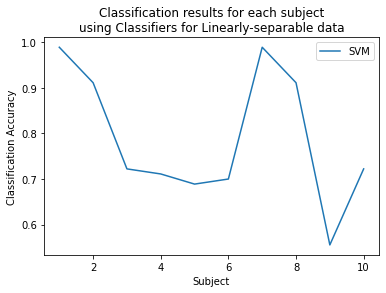

In [ ]:
print("   Subject,    Accuracy : ")
for i,a in enumerate(accuracy):
    print(f"     {i+1},       {a:.2f}")
    
print('-------------------------------')
means = np.mean(accuracy)
print('Average Classification Accuracy:', means)
a=accuracy
accuracy=np.array(accuracy)
#lr_accuracy = accuracy[:,0]
svm_accuracy = accuracy
#lda_accuracy = accuracy[:,2]
subjects_no = np.arange(1,11,1)

#plt.plot(subjects_no, lr_accuracy, label="Logistic Regression")
plt.plot(subjects_no, svm_accuracy, label="SVM")
#plt.plot(subjects_no, lda_accuracy, label="LDA")

plt.xlabel("Subject")
plt.ylabel("Classification Accuracy")
plt.title("Classification results for each subject\nusing Classifiers for Linearly-separable data")
plt.legend()
#plt.savefig("./results/Comparison of EEG Source Subjects - with channel selection.png", 
#             bbox_inches='tight', transparent=True, dpi=100)
plt.show()

#### Feet/Fists Movement Task - Imagined Movement Dataset - 10 subjects

In [ ]:
def train(X, y):
    n_components = np.arange(1,9)

    accuracy_svm = []
    
    best_model_svm=[]

    best_accuracy_svm=0
    
    for number in n_components:
        svm_score, svc = train_model(int(number), X, y)

        accuracy_svm.append( svm_score )

        if( svm_score>best_accuracy_svm ):
            best_accuracy_svm = svm_score
            best_model_svm = svc
            
    return np.max(accuracy_svm), best_model_svm



dataset_path = os.path.join("H:\\","BCI Project","eeg-motor-movementimagery-dataset-1.0.0","files\\")
subjects = [1,2,3,4,5,6,7,8,9,10]
runs = [6,10,14]
accuracy=[]
models=[]
f=[(8,30), (4,8), (4,12), (4,16)]

for subject in subjects:
    best_fband_acc = 0
    accuracy_svm = 0
    for freq in f:
        eeg = motorImagery(dataset_path, [subject], runs)
        eeg.apply_filter(freq=freq)
        X, y = eeg.get_X_y(channel_selection=False)
        accuracy_svm, model = train(X, y)
        if accuracy_svm>best_fband_acc:
            best_fband_acc = accuracy_svm
    accuracy.append(best_fband_acc)
    models.append(model)
    
print(accuracy)

Loading files at index: [5, 9, 13]
Loading file #3/3: H:\BCI Project\eeg-motor-movementimagery-dataset-1.0.0\files\S001/S001R14.edfLoading files at index: [5, 9, 13]
Loading file #3/3: H:\BCI Project\eeg-motor-movementimagery-dataset-1.0.0\files\S001/S001R14.edfLoading files at index: [5, 9, 13]
Loading file #3/3: H:\BCI Project\eeg-motor-movementimagery-dataset-1.0.0\files\S001/S001R14.edfLoading files at index: [5, 9, 13]
Loading file #3/3: H:\BCI Project\eeg-motor-movementimagery-dataset-1.0.0\files\S001/S001R14.edfLoading files at index: [19, 23, 27]
Loading file #3/3: H:\BCI Project\eeg-motor-movementimagery-dataset-1.0.0\files\S002/S002R14.edfLoading files at index: [19, 23, 27]
Loading file #3/3: H:\BCI Project\eeg-motor-movementimagery-dataset-1.0.0\files\S002/S002R14.edfLoading files at index: [19, 23, 27]
Loading file #3/3: H:\BCI Project\eeg-motor-movementimagery-dataset-1.0.0\files\S002/S002R14.edfLoading files at index: [19, 23, 27]
Loading file #3/3: H:\BCI Project\eeg-mo

   Subject,    Accuracy : 
     1,       0.99
     2,       0.91
     3,       0.73
     4,       0.87
     5,       0.69
     6,       0.70
     7,       0.97
     8,       0.91
     9,       0.62
     10,       0.77
-------------------------------
Average Classification Accuracy: 0.8155555555555557


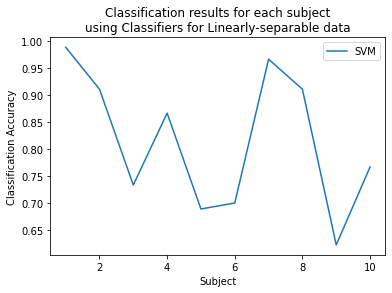

In [ ]:
print("   Subject,    Accuracy : ")
for i,a in enumerate(accuracy):
    print(f"     {i+1},       {a:.2f}")
    
print('-------------------------------')
means = np.mean(accuracy)
print('Average Classification Accuracy:', means)
a=accuracy
accuracy=np.array(accuracy)
#lr_accuracy = accuracy[:,0]
svm_accuracy = accuracy
#lda_accuracy = accuracy[:,2]
subjects_no = np.arange(1,11,1)

#plt.plot(subjects_no, lr_accuracy, label="Logistic Regression")
plt.plot(subjects_no, svm_accuracy, label="SVM")
#plt.plot(subjects_no, lda_accuracy, label="LDA")

plt.xlabel("Subject")
plt.ylabel("Classification Accuracy")
plt.title("Classification results for each subject\nusing Classifiers for Linearly-separable data")
plt.legend()
#plt.savefig("./results/Comparison of EEG Source Subjects - with channel selection.png", 
#             bbox_inches='tight', transparent=True, dpi=100)
plt.show()

#### Exp 3 - Imagined Feet/Fist Movement - Limiting the No. of CSP components

In [ ]:
def train(X, y):
    n_components = np.arange(1,6)

    accuracy_lda = []
    
    best_model_lda=[]

    best_accuracy_lda=0
    
    for number in n_components:
        lda_score, lda = train_model(int(number), X, y)

        accuracy_lda.append( lda_score )

        if( lda_score>best_accuracy_lda ):
            best_accuracy_lda = lda_score
            best_model_lda = lda
            
    return np.max(accuracy_lda), best_model_lda



dataset_path = os.path.join("/content/drive/MyDrive/EEG/files/")
subjects = [1,2,3,4,5,6,7,8,9,10]
runs = [6,10,14]
accuracy=[]
models=[]
f=[(4,8), (4,12), (4,16), (4,20), (8,12), (8,16), (8,28), (12,16), (12,20), (20,28), (20,32), (32,40)]

for subject in subjects:
    best_fband_acc = 0
    accuracy_lda = 0
    for freq in f:
        eeg = motorImagery(dataset_path, [subject], runs)
        eeg.apply_filter(freq=freq)
        X, y = eeg.get_X_y(channel_selection=False)
        accuracy_lda, model = train(X, y)
        if accuracy_lda>best_fband_acc:
            best_fband_acc = accuracy_lda
    accuracy.append(best_fband_acc)
    models.append(model)
    
print(accuracy)

Loading files at index: [5, 9, 13]
Loading file #3/3: /content/drive/MyDrive/EEG/files/S001/S001R14.edfLoading files at index: [5, 9, 13]
Loading file #3/3: /content/drive/MyDrive/EEG/files/S001/S001R14.edfLoading files at index: [5, 9, 13]
Loading file #3/3: /content/drive/MyDrive/EEG/files/S001/S001R14.edfLoading files at index: [5, 9, 13]
Loading file #3/3: /content/drive/MyDrive/EEG/files/S001/S001R14.edfLoading files at index: [5, 9, 13]
Loading file #3/3: /content/drive/MyDrive/EEG/files/S001/S001R14.edfLoading files at index: [5, 9, 13]
Loading file #3/3: /content/drive/MyDrive/EEG/files/S001/S001R14.edfLoading files at index: [5, 9, 13]
Loading file #3/3: /content/drive/MyDrive/EEG/files/S001/S001R14.edfLoading files at index: [5, 9, 13]
Loading file #3/3: /content/drive/MyDrive/EEG/files/S001/S001R14.edfLoading files at index: [5, 9, 13]
Loading file #3/3: /content/drive/MyDrive/EEG/files/S001/S001R14.edfLoading files at index: [5, 9, 13]
Loading file #3/3: /content/drive/MyDr

   Subject,    Accuracy : 
     1,       1.00
     2,       0.91
     3,       0.72
     4,       0.87
     5,       0.68
     6,       0.61
     7,       0.99
     8,       0.99
     9,       0.63
     10,       0.92
-------------------------------
Average Classification Accuracy: 0.83


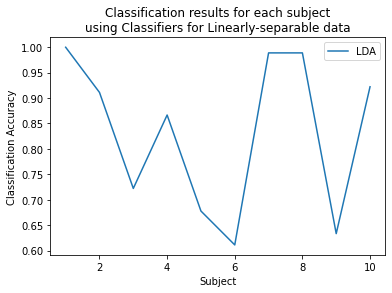

In [ ]:
print("   Subject,    Accuracy : ")
for i,a in enumerate(accuracy):
    print(f"     {i+1},       {a:.2f}")
    
print('-------------------------------')
means = np.mean(accuracy)
print(f'Average Classification Accuracy: {means:.2f}' )
a=accuracy
accuracy=np.array(accuracy)
#lr_accuracy = accuracy[:,0]
svm_accuracy = accuracy
#lda_accuracy = accuracy[:,2]
subjects_no = np.arange(1,11,1)

#plt.plot(subjects_no, lr_accuracy, label="Logistic Regression")
plt.plot(subjects_no, accuracy, label="LDA")
#plt.plot(subjects_no, lda_accuracy, label="LDA")

plt.xlabel("Subject")
plt.ylabel("Classification Accuracy")
plt.title("Classification results for each subject\nusing Classifiers for Linearly-separable data")
plt.legend()
#plt.savefig("./results/Comparison of EEG Source Subjects - with channel selection.png", 
#             bbox_inches='tight', transparent=True, dpi=100)
plt.show()

#### Exp 4 - Feet/Fists Movement Task - Real Movement Dataset - 10 subjects

In [ ]:
def train(X, y):
    n_components = np.arange(1,6)

    accuracy_lda = []
    
    best_model_lda=[]

    best_accuracy_lda=0
    
    for number in n_components:
        lda_score, lda = train_model(int(number), X, y)

        accuracy_lda.append( lda_score )

        if( lda_score>best_accuracy_lda ):
            best_accuracy_lda = lda_score
            best_model_lda = lda
            
    return np.max(accuracy_lda), best_model_lda



dataset_path = os.path.join("/content/drive/MyDrive/EEG/files/")
subjects = [1,2,3,4,5,6,7,8,9,10]
runs = [5,9,13]
accuracy=[]
models=[]
f=[(4,8), (4,12), (4,16), (4,20), (8,12), (8,16), (8,28), (12,16), (12,20), (20,28), (20,32), (32,40)]

for subject in subjects:
    best_fband_acc = 0
    accuracy_lda = 0
    for freq in f:
        eeg = motorImagery(dataset_path, [subject], runs)
        eeg.apply_filter(freq=freq)
        X, y = eeg.get_X_y(channel_selection=False)
        accuracy_lda, model = train(X, y)
        if accuracy_lda>best_fband_acc:
            best_fband_acc = accuracy_lda
    accuracy.append(best_fband_acc)
    models.append(model)
    
print(accuracy)

Loading files at index: [4, 8, 12]
Loading file #3/3: /content/drive/MyDrive/EEG/files/S001/S001R13.edfLoading files at index: [4, 8, 12]
Loading file #3/3: /content/drive/MyDrive/EEG/files/S001/S001R13.edfLoading files at index: [4, 8, 12]
Loading file #3/3: /content/drive/MyDrive/EEG/files/S001/S001R13.edfLoading files at index: [4, 8, 12]
Loading file #3/3: /content/drive/MyDrive/EEG/files/S001/S001R13.edfLoading files at index: [4, 8, 12]
Loading file #3/3: /content/drive/MyDrive/EEG/files/S001/S001R13.edfLoading files at index: [4, 8, 12]
Loading file #3/3: /content/drive/MyDrive/EEG/files/S001/S001R13.edfLoading files at index: [4, 8, 12]
Loading file #3/3: /content/drive/MyDrive/EEG/files/S001/S001R13.edfLoading files at index: [4, 8, 12]
Loading file #3/3: /content/drive/MyDrive/EEG/files/S001/S001R13.edfLoading files at index: [4, 8, 12]
Loading file #3/3: /content/drive/MyDrive/EEG/files/S001/S001R13.edfLoading files at index: [4, 8, 12]
Loading file #3/3: /content/drive/MyDr

   Subject,    Accuracy : 
     1,       1.00
     2,       1.00
     3,       0.68
     4,       0.98
     5,       0.98
     6,       0.64
     7,       1.00
     8,       0.84
     9,       0.83
     10,       1.00
-------------------------------
Average Classification Accuracy: 0.90


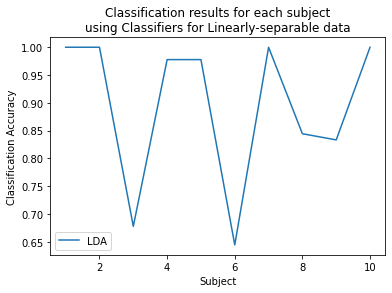

In [ ]:
print("   Subject,    Accuracy : ")
for i,a in enumerate(accuracy):
    print(f"     {i+1},       {a:.2f}")
    
print('-------------------------------')
means = np.mean(accuracy)
print(f'Average Classification Accuracy: {means:.2f}' )
a=accuracy
accuracy=np.array(accuracy)
#lr_accuracy = accuracy[:,0]
svm_accuracy = accuracy
#lda_accuracy = accuracy[:,2]
subjects_no = np.arange(1,11,1)

#plt.plot(subjects_no, lr_accuracy, label="Logistic Regression")
plt.plot(subjects_no, accuracy, label="LDA")
#plt.plot(subjects_no, lda_accuracy, label="LDA")

plt.xlabel("Subject")
plt.ylabel("Classification Accuracy")
plt.title("Classification results for each subject\nusing Classifiers for Linearly-separable data")
plt.legend()
#plt.savefig("./results/Comparison of EEG Source Subjects - with channel selection.png", 
#             bbox_inches='tight', transparent=True, dpi=100)
plt.show()

#### Exp 5 - Left/Right Fist Classification - Real Movement

In [ ]:
def train(X, y):
    n_components = np.arange(1,6)

    accuracy_svm = []
    
    best_model_svm=[]

    best_accuracy_svm=0
    
    for number in n_components:
        svm_score, svc = train_model(int(number), X, y)

        accuracy_svm.append( svm_score )

        if( svm_score>best_accuracy_svm ):
            best_accuracy_svm = svm_score
            best_model_svm = svc
            
    return np.max(accuracy_svm), best_model_svm



dataset_path = os.path.join("H:\\","BCI Project","eeg-motor-movementimagery-dataset-1.0.0","files\\")
subjects = [1,2,3,4,5,6,7,8,9,10]
runs = [3,7,11]
accuracy=[]
models=[]
f=[(8,28), (4,8), (4,12), (4,16)]

for subject in subjects:
    best_fband_acc = 0
    accuracy_svm = 0
    for freq in f:
        eeg = motorImagery(dataset_path, [subject], runs)
        eeg.apply_filter(freq=freq)
        X, y = eeg.get_X_y(channel_selection=False)
        accuracy_svm, model = train(X, y)
        if accuracy_svm>best_fband_acc:
            best_fband_acc = accuracy_svm
    accuracy.append(best_fband_acc)
    models.append(model)
    
print(accuracy)

Loading files at index: [2, 6, 10]
Loading file #3/3: H:\BCI Project\eeg-motor-movementimagery-dataset-1.0.0\files\S001/S001R11.edfLoading files at index: [2, 6, 10]
Loading file #3/3: H:\BCI Project\eeg-motor-movementimagery-dataset-1.0.0\files\S001/S001R11.edfLoading files at index: [2, 6, 10]
Loading file #3/3: H:\BCI Project\eeg-motor-movementimagery-dataset-1.0.0\files\S001/S001R11.edfLoading files at index: [2, 6, 10]
Loading file #3/3: H:\BCI Project\eeg-motor-movementimagery-dataset-1.0.0\files\S001/S001R11.edfLoading files at index: [16, 20, 24]
Loading file #3/3: H:\BCI Project\eeg-motor-movementimagery-dataset-1.0.0\files\S002/S002R11.edfLoading files at index: [16, 20, 24]
Loading file #3/3: H:\BCI Project\eeg-motor-movementimagery-dataset-1.0.0\files\S002/S002R11.edfLoading files at index: [16, 20, 24]
Loading file #3/3: H:\BCI Project\eeg-motor-movementimagery-dataset-1.0.0\files\S002/S002R11.edfLoading files at index: [16, 20, 24]
Loading file #3/3: H:\BCI Project\eeg-mo

   Subject,    Accuracy : 
     1,       0.66
     2,       0.59
     3,       0.67
     4,       0.70
     5,       0.67
     6,       0.70
     7,       0.99
     8,       0.71
     9,       0.87
     10,       0.88
-------------------------------
Average Classification Accuracy: 0.74


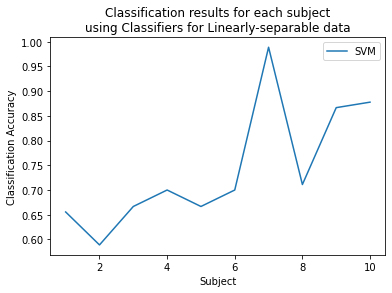

In [ ]:
print("   Subject,    Accuracy : ")
for i,a in enumerate(accuracy):
    print(f"     {i+1},       {a:.2f}")
    
print('-------------------------------')
means = np.mean(accuracy)
print(f'Average Classification Accuracy: {means:.2f}' )
a=accuracy
accuracy=np.array(accuracy)
#lr_accuracy = accuracy[:,0]
svm_accuracy = accuracy
#lda_accuracy = accuracy[:,2]
subjects_no = np.arange(1,11,1)

#plt.plot(subjects_no, lr_accuracy, label="Logistic Regression")
plt.plot(subjects_no, svm_accuracy, label="SVM")
#plt.plot(subjects_no, lda_accuracy, label="LDA")

plt.xlabel("Subject")
plt.ylabel("Classification Accuracy")
plt.title("Classification results for each subject\nusing Classifiers for Linearly-separable data")
plt.legend()
#plt.savefig("./results/Comparison of EEG Source Subjects - with channel selection.png", 
#             bbox_inches='tight', transparent=True, dpi=100)
plt.show()

Left/Right Fist - Real Movement Dataset - 10 Subjects

In [ ]:
def train(X, y):
    n_components = np.arange(1,6,1)

    accuracy_svm = []
    
    best_model_svm=[]

    best_accuracy_svm=0
    
    for number in n_components:
        svm_score, svc = train_model(int(number), X, y)

        accuracy_svm.append( svm_score )

        if( svm_score>best_accuracy_svm ):
            best_accuracy_svm = svm_score
            best_model_svm = svc
            
    return np.max(accuracy_svm), best_model_svm



dataset_path = os.path.join("/content/drive/MyDrive/EEG/files/")
subjects = [1,2,3,4,5,6,7,8,9,10]
runs = [3,7,11]
accuracy=[]
models=[]
f=[(4,8), (4,12), (4,16), (4,20), (8,12), (8,16), (8,28), (12,16), (12,20), (20,28), (20,32), (32,40)]

for subject in subjects:
    best_fband_acc = 0
    accuracy_svm = 0
    for freq in f:
        eeg = motorImagery(dataset_path, [subject], runs)
        eeg.apply_filter(freq=freq)
        X, y = eeg.get_X_y(channel_selection=False)
        accuracy_svm, model = train(X, y)
        if accuracy_svm>best_fband_acc:
            best_fband_acc = accuracy_svm
    accuracy.append(best_fband_acc)
    models.append(model)
    
print(accuracy)

Loading files at index: [2, 6, 10]
Loading file #3/3: /content/drive/MyDrive/EEG/files/S001/S001R11.edfLoading files at index: [2, 6, 10]
Loading file #3/3: /content/drive/MyDrive/EEG/files/S001/S001R11.edfLoading files at index: [2, 6, 10]
Loading file #3/3: /content/drive/MyDrive/EEG/files/S001/S001R11.edfLoading files at index: [2, 6, 10]
Loading file #3/3: /content/drive/MyDrive/EEG/files/S001/S001R11.edfLoading files at index: [2, 6, 10]
Loading file #3/3: /content/drive/MyDrive/EEG/files/S001/S001R11.edfLoading files at index: [2, 6, 10]
Loading file #3/3: /content/drive/MyDrive/EEG/files/S001/S001R11.edfLoading files at index: [2, 6, 10]
Loading file #3/3: /content/drive/MyDrive/EEG/files/S001/S001R11.edfLoading files at index: [2, 6, 10]
Loading file #3/3: /content/drive/MyDrive/EEG/files/S001/S001R11.edfLoading files at index: [2, 6, 10]
Loading file #3/3: /content/drive/MyDrive/EEG/files/S001/S001R11.edfLoading files at index: [2, 6, 10]
Loading file #3/3: /content/drive/MyDr

   Subject,    Accuracy : 
     1,       0.73
     2,       0.63
     3,       0.67
     4,       0.70
     5,       0.67
     6,       0.70
     7,       1.00
     8,       0.71
     9,       0.87
     10,       0.90
-------------------------------
Average Classification Accuracy: 0.76


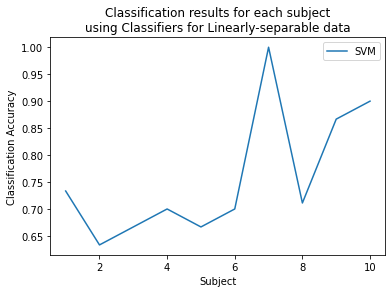

In [ ]:
print("   Subject,    Accuracy : ")
for i,a in enumerate(accuracy):
    print(f"     {i+1},       {a:.2f}")
    
print('-------------------------------')
means = np.mean(accuracy)
print(f'Average Classification Accuracy: {means:.2f}' )
a=accuracy
accuracy=np.array(accuracy)
#lr_accuracy = accuracy[:,0]
svm_accuracy = accuracy
#lda_accuracy = accuracy[:,2]
subjects_no = np.arange(1,11,1)

#plt.plot(subjects_no, lr_accuracy, label="Logistic Regression")
plt.plot(subjects_no, svm_accuracy, label="SVM")
#plt.plot(subjects_no, lda_accuracy, label="LDA")

plt.xlabel("Subject")
plt.ylabel("Classification Accuracy")
plt.title("Classification results for each subject\nusing Classifiers for Linearly-separable data")
plt.legend()
#plt.savefig("./results/Comparison of EEG Source Subjects - with channel selection.png", 
#             bbox_inches='tight', transparent=True, dpi=100)
plt.show()

Feet/Fists Movement Task - Real Movement Dataset - 20 subjects

In [ ]:
def train(X, y):
    n_components = np.arange(1,6)

    accuracy_lda = []
    
    best_model_lda=[]

    best_accuracy_lda=0
    
    for number in n_components:
        lda_score, lda = train_model(int(number), X, y)

        accuracy_lda.append( lda_score )

        if( lda_score>best_accuracy_lda ):
            best_accuracy_lda = lda_score
            best_model_lda = lda
            
    return np.max(accuracy_lda), best_model_lda


dataset_path = os.path.join("/content/drive/MyDrive/EEG/files/")
subjects = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
runs = [5,9,13]
accuracy=[]
models=[]
f=[(8,28), (4,8), (4,12), (4,16)]

for subject in subjects:
    best_fband_acc = 0
    accuracy_lda = 0
    for freq in f:
        eeg = motorImagery(dataset_path, [subject], runs)
        eeg.apply_filter(freq=freq)
        X, y = eeg.get_X_y(channel_selection=False)
        accuracy_lda, model = train(X, y)
        if accuracy_lda>best_fband_acc:
            best_fband_acc = accuracy_lda
    accuracy.append(best_fband_acc)
    models.append(model)
    
print(accuracy)


Loading files at index: [4, 8, 12]
Loading file #3/3: /content/drive/MyDrive/EEG/files/S001/S001R13.edfLoading files at index: [4, 8, 12]
Loading file #3/3: /content/drive/MyDrive/EEG/files/S001/S001R13.edfLoading files at index: [4, 8, 12]
Loading file #3/3: /content/drive/MyDrive/EEG/files/S001/S001R13.edfLoading files at index: [4, 8, 12]
Loading file #3/3: /content/drive/MyDrive/EEG/files/S001/S001R13.edfLoading files at index: [18, 22, 26]
Loading file #3/3: /content/drive/MyDrive/EEG/files/S002/S002R13.edfLoading files at index: [18, 22, 26]
Loading file #3/3: /content/drive/MyDrive/EEG/files/S002/S002R13.edfLoading files at index: [18, 22, 26]
Loading file #3/3: /content/drive/MyDrive/EEG/files/S002/S002R13.edfLoading files at index: [18, 22, 26]
Loading file #3/3: /content/drive/MyDrive/EEG/files/S002/S002R13.edfLoading files at index: [32, 36, 40]
Loading file #3/3: /content/drive/MyDrive/EEG/files/S003/S003R13.edfLoading files at index: [32, 36, 40]
Loading file #3/3: /conten

   Subject,    Accuracy : 
     1,       1.00
     2,       1.00
     3,       0.64
     4,       0.94
     5,       0.83
     6,       0.51
     7,       1.00
     8,       0.76
     9,       0.82
     10,       0.97
     11,       0.68
     12,       0.89
     13,       0.94
     14,       1.00
     15,       0.83
     16,       0.83
     17,       0.80
     18,       0.77
     19,       0.98
     20,       0.59
-------------------------------
Average Classification Accuracy: 0.84


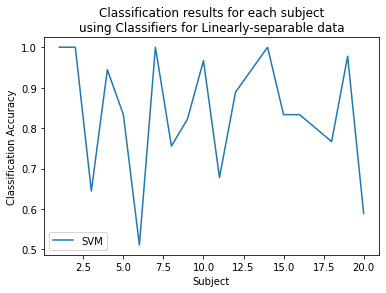

In [ ]:
print("   Subject,    Accuracy : ")
for i,a in enumerate(accuracy):
    print(f"     {i+1},       {a:.2f}")
    
print('-------------------------------')
means = np.mean(accuracy)
print(f'Average Classification Accuracy: {means:.2f}' )
a=accuracy
accuracy=np.array(accuracy)
#lr_accuracy = accuracy[:,0]
svm_accuracy = accuracy
#lda_accuracy = accuracy[:,2]
subjects_no = np.arange(1,21,1)

#plt.plot(subjects_no, lr_accuracy, label="Logistic Regression")
plt.plot(subjects_no, svm_accuracy, label="SVM")
#plt.plot(subjects_no, lda_accuracy, label="LDA")

plt.xlabel("Subject")
plt.ylabel("Classification Accuracy")
plt.title("Classification results for each subject\nusing Classifiers for Linearly-separable data")
plt.legend()
#plt.savefig("./results/Comparison of EEG Source Subjects - with channel selection.png", 
#             bbox_inches='tight', transparent=True, dpi=100)
plt.show()

Feet/Fists Movement - Real + Imagined - 20 Subjects

In [ ]:
def train(X, y):
    n_components = np.arange(1,6)

    accuracy_lda = []
    
    best_model_lda=[]

    best_accuracy_lda=0
    
    for number in n_components:
        lda_score, lda = train_model(int(number), X, y)

        accuracy_lda.append( lda_score )

        if( lda_score>best_accuracy_lda ):
            best_accuracy_lda = lda_score
            best_model_lda = lda
            
    return np.max(accuracy_lda), best_model_lda


dataset_path = os.path.join("/content/drive/MyDrive/EEG/files/")
subjects = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
runs = [5,6,9,10,13,14]
accuracy=[]
models=[]
f=[(8,28), (4,8), (4,12), (4,16)]

for subject in subjects:
    best_fband_acc = 0
    accuracy_lda = 0
    for freq in f:
        eeg = motorImagery(dataset_path, [subject], runs)
        eeg.apply_filter(freq=freq)
        X, y = eeg.get_X_y(channel_selection=False)
        accuracy_lda, model = train(X, y)
        if accuracy_lda>best_fband_acc:
            best_fband_acc = accuracy_lda
    accuracy.append(best_fband_acc)
    models.append(model)
    
print(accuracy)

Loading files at index: [4, 5, 8, 9, 12, 13]
Loading file #6/6: /content/drive/MyDrive/EEG/files/S001/S001R14.edfLoading files at index: [4, 5, 8, 9, 12, 13]
Loading file #6/6: /content/drive/MyDrive/EEG/files/S001/S001R14.edfLoading files at index: [4, 5, 8, 9, 12, 13]
Loading file #6/6: /content/drive/MyDrive/EEG/files/S001/S001R14.edfLoading files at index: [4, 5, 8, 9, 12, 13]
Loading file #6/6: /content/drive/MyDrive/EEG/files/S001/S001R14.edfLoading files at index: [18, 19, 22, 23, 26, 27]
Loading file #6/6: /content/drive/MyDrive/EEG/files/S002/S002R14.edfLoading files at index: [18, 19, 22, 23, 26, 27]
Loading file #6/6: /content/drive/MyDrive/EEG/files/S002/S002R14.edfLoading files at index: [18, 19, 22, 23, 26, 27]
Loading file #6/6: /content/drive/MyDrive/EEG/files/S002/S002R14.edfLoading files at index: [18, 19, 22, 23, 26, 27]
Loading file #6/6: /content/drive/MyDrive/EEG/files/S002/S002R14.edfLoading files at index: [32, 33, 36, 37, 40, 41]
Loading file #6/6: /content/dri

   Subject,    Accuracy : 
     1,       0.98
     2,       0.93
     3,       0.67
     4,       0.83
     5,       0.71
     6,       0.61
     7,       0.99
     8,       0.72
     9,       0.68
     10,       0.92
     11,       0.80
     12,       0.94
     13,       0.78
     14,       0.80
     15,       0.91
     16,       0.63
     17,       0.78
     18,       0.63
     19,       0.81
     20,       0.51
-------------------------------
Average Classification Accuracy: 0.78


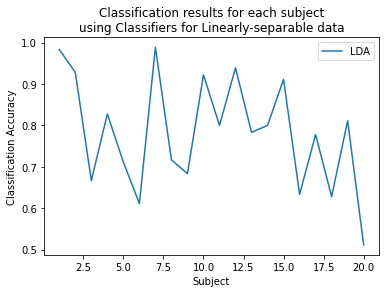

In [ ]:
print("   Subject,    Accuracy : ")
for i,a in enumerate(accuracy):
    print(f"     {i+1},       {a:.2f}")
    
print('-------------------------------')
means = np.mean(accuracy)
print(f'Average Classification Accuracy: {means:.2f}' )
a=accuracy
accuracy=np.array(accuracy)
#lr_accuracy = accuracy[:,0]
svm_accuracy = accuracy
#lda_accuracy = accuracy[:,2]
subjects_no = np.arange(1,21,1)

#plt.plot(subjects_no, lr_accuracy, label="Logistic Regression")
plt.plot(subjects_no, accuracy, label="LDA")
#plt.plot(subjects_no, lda_accuracy, label="LDA")

plt.xlabel("Subject")
plt.ylabel("Classification Accuracy")
plt.title("Classification results for each subject\nusing Classifiers for Linearly-separable data")
plt.legend()
#plt.savefig("./results/Comparison of EEG Source Subjects - with channel selection.png", 
#             bbox_inches='tight', transparent=True, dpi=100)
plt.show()

Left/Right Fist - Real + Imagined - 20 Subjects

In [ ]:
def train(X, y):
    n_components = np.arange(1,6,1)

    accuracy_svm = []
    
    best_model_svm=[]

    best_accuracy_svm=0
    
    for number in n_components:
        svm_score, svc = train_model(int(number), X, y)

        accuracy_svm.append( svm_score )

        if( svm_score>best_accuracy_svm ):
            best_accuracy_svm = svm_score
            best_model_svm = svc
            
    return np.max(accuracy_svm), best_model_svm



dataset_path = os.path.join("/content/drive/MyDrive/EEG/files/")
subjects = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
runs = [3,4,7,8,11,12]
accuracy=[]
models=[]
f=[(4,8), (4,12), (4,16), (4,20), (8,12), (8,16), (8,28), (12,16), (12,20), (20,28), (20,32), (32,40)]

for subject in subjects:
    best_fband_acc = 0
    accuracy_svm = 0
    for freq in f:
        eeg = motorImagery(dataset_path, [subject], runs)
        eeg.apply_filter(freq=freq)
        X, y = eeg.get_X_y(channel_selection=False)
        accuracy_svm, model = train(X, y)
        if accuracy_svm>best_fband_acc:
            best_fband_acc = accuracy_svm
    accuracy.append(best_fband_acc)
    models.append(model)
    
print(accuracy)

Loading files at index: [2, 3, 6, 7, 10, 11]
Loading file #6/6: /content/drive/MyDrive/EEG/files/S001/S001R12.edfLoading files at index: [2, 3, 6, 7, 10, 11]
Loading file #6/6: /content/drive/MyDrive/EEG/files/S001/S001R12.edfLoading files at index: [2, 3, 6, 7, 10, 11]
Loading file #6/6: /content/drive/MyDrive/EEG/files/S001/S001R12.edfLoading files at index: [2, 3, 6, 7, 10, 11]
Loading file #6/6: /content/drive/MyDrive/EEG/files/S001/S001R12.edfLoading files at index: [2, 3, 6, 7, 10, 11]
Loading file #6/6: /content/drive/MyDrive/EEG/files/S001/S001R12.edfLoading files at index: [2, 3, 6, 7, 10, 11]
Loading file #6/6: /content/drive/MyDrive/EEG/files/S001/S001R12.edfLoading files at index: [2, 3, 6, 7, 10, 11]
Loading file #6/6: /content/drive/MyDrive/EEG/files/S001/S001R12.edfLoading files at index: [2, 3, 6, 7, 10, 11]
Loading file #6/6: /content/drive/MyDrive/EEG/files/S001/S001R12.edfLoading files at index: [2, 3, 6, 7, 10, 11]
Loading file #6/6: /content/drive/MyDrive/EEG/files

   Subject,    Accuracy : 
     1,       0.88
     2,       0.77
     3,       0.72
     4,       0.69
     5,       0.57
     6,       0.59
     7,       0.99
     8,       0.60
     9,       0.72
     10,       0.86
     11,       0.63
     12,       0.54
     13,       0.77
     14,       0.63
     15,       0.62
     16,       0.73
     17,       0.59
     18,       0.63
     19,       0.79
     20,       0.64
-------------------------------
Average Classification Accuracy: 0.70


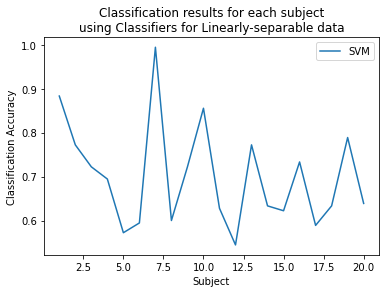

In [ ]:
print("   Subject,    Accuracy : ")
for i,a in enumerate(accuracy):
    print(f"     {i+1},       {a:.2f}")
    
print('-------------------------------')
means = np.mean(accuracy)
print(f'Average Classification Accuracy: {means:.2f}' )
a=accuracy
accuracy=np.array(accuracy)
#lr_accuracy = accuracy[:,0]
svm_accuracy = accuracy
#lda_accuracy = accuracy[:,2]
subjects_no = np.arange(1,21,1)

#plt.plot(subjects_no, lr_accuracy, label="Logistic Regression")
plt.plot(subjects_no, svm_accuracy, label="SVM")
#plt.plot(subjects_no, lda_accuracy, label="LDA")

plt.xlabel("Subject")
plt.ylabel("Classification Accuracy")
plt.title("Classification results for each subject\nusing Classifiers for Linearly-separable data")
plt.legend()
#plt.savefig("./results/Comparison of EEG Source Subjects - with channel selection.png", 
#             bbox_inches='tight', transparent=True, dpi=100)
plt.show()